[Paper](https://arxiv.org/pdf/1806.02375) | [This notebook](main.ipynb)

The paper investigates the cause of batch norm's benefits experimentally. The authors show that its main benefit is allowing for larger learning rates during training. In particular: 

>"We show that the activations
and gradients in deep neural networks without BN tend to be heavy-tailed. In particular, during an
early on-set of divergence, a small subset of activations (typically in deep layer) “explode”. The
typical practice to avoid such divergence is to set the learning rate to be sufficiently small such that
no steep gradient direction can lead to divergence. However, small learning rates yield little progress
along flat directions of the optimization landscape and may be more prone to convergence to sharp
local minima with possibly worse generalization performance."

The experiments are primarily done with a ResNet 110 trained on CIFAR-10. We will attempt to reproduce figures 1-6. 

### Convolutional BN Layer

As a reminder, the input $I$ and output $O$ tensors to a batch norm layer are 4 dimentional. The dimentions $(b, c, x, y)$ correspond to the batch example, channel and spatial $x$, $y$ dimentions respectively. Batch norm (BN) applies a channel-wise normalization:

$$
O_{b, c, x, y} \leftarrow \gamma_c \frac{I_{b, c, x, y} - \hat \mu_c}{\sqrt{\hat \sigma_c^2 + \epsilon}} + \beta_c
$$

Where $\hat \mu_c$ and $\hat \sigma_c^2$ are estimates channel $c$'s mean and standard deviation computed on the minibatch $\mathcal B$:

$$
\hat \mu_c = \frac{1}{|\mathcal B|}\sum_{b, x, y} I_{b, c, x, y}
$$

$$
\hat \sigma_c^2 = \frac{1}{\mathcal |B|} \sum_{b, x, y} (I_{b, c, x, y} - \hat \mu_c) ^ 2
$$

To make sure the layer does not loose expressive power we introduce learned parameters $\gamma_c$ and $\beta_c$. $\epsilon$ is a small constant added for numerical stability. In pytorch we can simply use the `BatchNorm2d` layer. 

### Experimental setup

Let's setup our data loaders, model and training loop as described in Appendix B of the paper.

In [1]:
#| code-summary: Imports and model evaluation function
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from PIL import Image

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, itertools, time

os.makedirs('logs', exist_ok = True)
os.makedirs('models', exist_ok = True)

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device(
    'cuda' if torch.cuda.is_available() else
    ('mps' if torch.backends.mps.is_available() else
    'cpu')
)

def eval_model(model, test, criterion = nn.CrossEntropyLoss()):
    model.eval()
    correct, loss = 0, 0.0
    with torch.no_grad():
        for images, labels in test:
            images, labels = images.to(device), labels.to(device)
            _, pred = torch.max(model(images), 1)
            correct += (pred == labels).float().sum().item()
            loss += criterion(model(images), labels).item()
    return loss / len(test.dataset), correct / len(test.dataset)

device

device(type='mps')

The paper trains ResNet-101s (110 in the paper is a typo?) on CIFAR-10, with channel-wise normalization, random horizontal flipping, and 32-by-32 cropping with 4-pixel zero padding.

We first get the datasets and compute the channel-wise means and variances. Note: both the training and validation set have the same values.

In [2]:
#| code-summary: Datasets and channel-wise means and stds
#| output: false
train_set = datasets.CIFAR10('./data', download = True, train = True, transform = transforms.ToTensor())
val_set = datasets.CIFAR10('./data', download = True, train = False, transform = transforms.ToTensor())

def channel_means_stds(dataset):
    imgs = torch.stack([img for img, _ in train_set])
    return imgs.mean(dim = [0, 2, 3]), imgs.std(dim = [0, 2, 3])

means, stds = channel_means_stds(train_set)
print(f'Training channel-wise\n\tmeans: {means}\n\tstds: {stds}')

means, stds = channel_means_stds(val_set)
print(f'Validation channel-wise\n\tmeans: {means}\n\tstds: {stds}')

Files already downloaded and verified
Files already downloaded and verified
Training channel-wise
	means: tensor([0.4914, 0.4822, 0.4465])
	stds: tensor([0.2470, 0.2435, 0.2616])
Validation channel-wise
	means: tensor([0.4914, 0.4822, 0.4465])
	stds: tensor([0.2470, 0.2435, 0.2616])


We now define the transforms with data aumentation and data loaders with batch size $128$.

In [3]:
#| output: false
#| code-summary: Data transforms and data loaders

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding = 4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

# We do not perform data augmentation on the validation set
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(means, stds),
])

train_set.transform = train_transform
val_set.transform = val_transform

train_loader = DataLoader(train_set, batch_size = 128, shuffle = True)
val_loader = DataLoader(val_set, batch_size = 128, shuffle = False)

We'll use `torchvision`'s implementation of ResNet-101, Xavier initialization, SGD with momentum $0.9$ and
weight decay $5\times 10^{-4}$, and cross entropy loss. We implement the learning rate schedule and training details mentioned:

>"Initially, all models are trained for 165 epochs and as in [17]
we divide the learning rate by 10 after epoch 50% and 75%, at which point learning has typically
plateued. If learning doesn’t plateu for some number of epochs, we roughly double the number of
epochs until it does".

In [38]:
#| code-summary: Init, and train functions
#| output: false

def xavier_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)

def train_epoch(model, train, optimizer, criterion):
    # Trains the model for one epoch
    model.train()
    train_loss, correct = 0.0, 0
    for images, labels in train:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, pred = torch.max(output, 1)
        correct += (pred == labels).float().sum().item()
    return train_loss / len(train.dataset), correct / len(train.dataset)


def train(model, train, val, init_lr, plateau_patience = 20):

    optimizer = optim.SGD(model.parameters(), lr = init_lr, momentum = 0.9, weight_decay = 5e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose = True)
    criterion = nn.CrossEntropyLoss()

    model.to(device)

    init_epochs = 165

    epoch = 0
    plateau_count = 0
    best_loss = None

    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    while epoch < init_epochs and plateau_count < plateau_patience:

        # Train the model for an epoch
        loss, acc = train_epoch(model, train, optimizer, criterion)
        train_losses.append(loss)
        train_accs.append(acc)

        # Evaluate the model on the validation set
        val_loss, val_acc = eval_model(model, val, criterion)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Update the learning rate
        scheduler.step(val_loss)

        # Check for a plateau
        if best_loss is None or val_loss < best_loss:
            best_loss = val_loss
            plateau_count = 0
        else:
            plateau_count += 1
        
        epoch += 1

        # "If learning doesn’t plateu for some number of epochs,
        # we roughly double the number of epochs until it does."
        if epoch == init_epochs and plateau_count < plateau_patience:
            init_epochs *= 2

        print(f'Epoch {epoch}/{init_epochs} | Learning Rate: {optimizer.param_groups[0]["lr"]}'
              f'Training loss: {train_losses[-1]:.4f} | '
              f'Validation loss: {val_losses[-1]:.4f} | '
              f'Validation accuracy: {val_accs[-1]:.4f}')
        
    return train_losses, train_accs, val_losses, val_accs

And we define a function to disable batch norm layers in a model by replacing them for identity layers:

In [39]:
#|code-fold: false
#|code-summary: Function to disable batch normalization

def disable_bn(model):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            setattr(model, name, nn.Identity())
        else:
            disable_bn(module)  # Recursively replace in child modules

### Fig 1

In [40]:
#| code-summary: Train models
#| output: false

for lr, bn in [(0.0001, False), (0.0001, True), (0.1, True), (0.003, True)]:

    s = f'lr={lr}' + ('_bn' if bn else '')
    print(s)

    model = models.resnet18()
    model.apply(xavier_init)

    if not bn: disable_bn(model)

    torch.save(model, 'models/'+ s + '_init.tmp')
    data = train(model, train_loader, val_loader, init_lr = lr)
    torch.save(model, 'models/'+ s + '_end.tmp')
    torch.save(data, 'logs/'+ s + '.tmp')

lr=0.0001
Epoch 1/165 | Learning Rate: 0.0001Training loss: 0.0362 | Validation loss: 0.0181 | Validation accuracy: 0.1510
Epoch 2/165 | Learning Rate: 0.0001Training loss: 0.0176 | Validation loss: 0.0176 | Validation accuracy: 0.1789
Epoch 3/165 | Learning Rate: 0.0001Training loss: 0.0170 | Validation loss: 0.0168 | Validation accuracy: 0.2308
Epoch 4/165 | Learning Rate: 0.0001Training loss: 0.0165 | Validation loss: 0.0163 | Validation accuracy: 0.2568
Epoch 5/165 | Learning Rate: 0.0001Training loss: 0.0160 | Validation loss: 0.0157 | Validation accuracy: 0.2870
Epoch 6/165 | Learning Rate: 0.0001Training loss: 0.0155 | Validation loss: 0.0153 | Validation accuracy: 0.3034
Epoch 7/165 | Learning Rate: 0.0001Training loss: 0.0151 | Validation loss: 0.0150 | Validation accuracy: 0.3127
Epoch 8/165 | Learning Rate: 0.0001Training loss: 0.0148 | Validation loss: 0.0147 | Validation accuracy: 0.3359
Epoch 9/165 | Learning Rate: 0.0001Training loss: 0.0145 | Validation loss: 0.0143 | V

lr=0.0001 79
lr=0.1_bn 21
lr=0.0001_bn 93
lr=0.003_bn 38


Text(0, 0.5, 'Training accuracy')

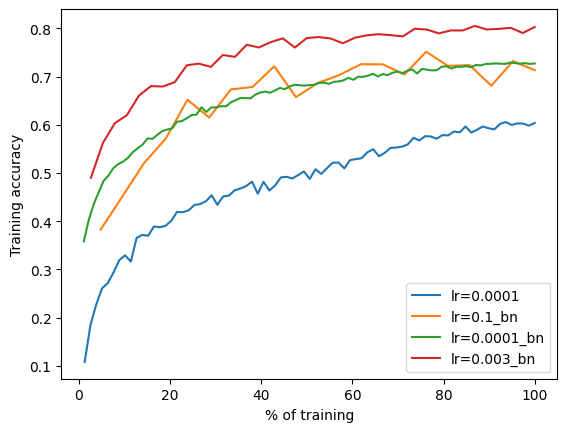

In [32]:
# code-summary: Plot results

get_x = lambda x: 100 * np.arange(1, len(x) + 1) / len(x)

for fname in os.listdir('logs'):
    train_losses, train_accs, val_losses, val_accs = torch.load('logs/' + fname)
    print(fname[:-4], len(train_accs))
    plt.plot(get_x(train_accs), val_accs, label = fname[:-4])

plt.legend()
plt.xlabel('% of training')
plt.ylabel('Training accuracy')

### Fig 2

In [1]:
layer_name = 'layer3.8.conv2.weight' #'layer3.9.conv3.weight'
with_bn, without_bn = [], []
n_steps = 0

model = models.resnet101()
model.apply(xavier_init)
model.train()
model.to(device)

criterion = nn.CrossEntropyLoss()

for bn, l in zip([True, False], [with_bn, without_bn]):

    # model = models.resnet101()
    # model.apply(xavier_init)
    # model.train()
    # model.to(device)

    if not bn: disable_bn(model)
    optimizer = optim.SGD(model.parameters(), lr = 0.1, momentum = 0.9, weight_decay = 5e-4)

    for i, (images, labels) in enumerate(val_loader):

        model.train()
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        if i <= n_steps - 1:
            print('step')
            optimizer.step()

        model.eval()

        for name, param in model.named_parameters():
            if name == layer_name:
                # l.append((param.grad ** 2).sum().item())
                print((param.grad.view(-1) ** 2).sum().sqrt().item())
                if i >= n_steps - 1: l.extend(param.grad.view(-1)[:100000].cpu().detach().tolist())
                break

        if i >= n_steps - 1: break
    
    break
        

NameError: name 'models' is not defined

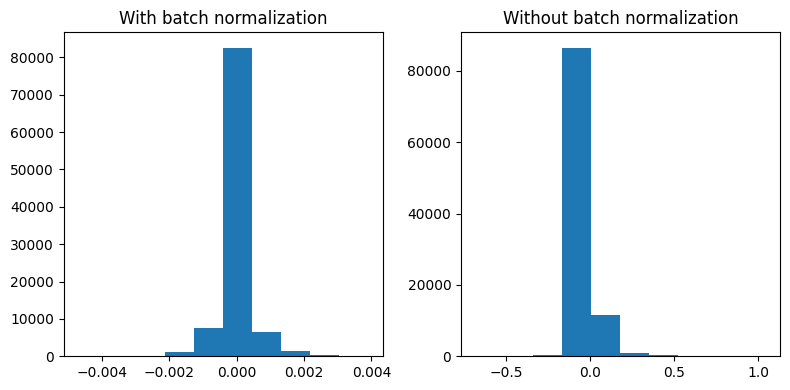

: 

In [50]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
ax1.hist(with_bn)
# sns.histplot(with_bn, ax = ax1)
ax1.set_title('With batch normalization')
# ax1.set_xlim(-0.05, 0.05)
# ax1.set_yscale('log')

ax2.hist(without_bn)
# sns.histplot(without_bn, ax = ax2)
ax2.set_title('Without batch normalization')
# ax2.set_ylim((0, 600))
# ax2.set_yscale('log')

f.tight_layout()

### What I learned

- How to do image augmentation
- Scheduler